IMPORT LIBRARY

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import joblib
import random

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix
)

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input

# SET SEED (REPRODUCIBILITY)

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

LOAD DATA

In [2]:

# LOAD DATA

df = pd.read_csv('/content/Data1.csv')
df.head()

,TextID,URL,Label,totalWordsCount,semanticobjscore,semanticsubjscore,CC,CD,DT,EX,...,pronouns2nd,pronouns3rd,compsupadjadv,past,imperative,present3rd,present1st2nd,sentence1st,sentencelast,txtcomplexity
0,Text0001,http://msn.foxsports.com/foxsoccer/mexico/stor...,objective,109,0,1,7,9,0,5,...,0,3,0,11,0,0,0,0,1,18
1,Text0002,http://msn.foxsports.com/foxsoccer/premierleag...,objective,309,21,4,1,19,1,4,...,0,10,0,13,0,14,9,1,1,14
2,Text0003,http://uk.eurosport.yahoo.com/04022011/58/fed-...,objective,149,6,1,8,14,0,5,...,0,2,0,8,0,3,2,1,1,18
3,Text0004,http://uk.eurosport.yahoo.com/07022011/58/bund...,objective,305,18,5,7,26,0,10,...,0,8,3,13,1,7,1,1,1,20
4,Text0005,http://uk.eurosport.yahoo.com/05022011/58/fed-...,objective,491,23,8,33,47,0,12,...,0,16,2,34,1,5,6,1,1,24


Data Cleaning

In [3]:
# DATA CLEANING

# Drop duplicate rows
df = df.drop_duplicates().reset_index(drop=True)

# Imputasi missing values hanya untuk kolom numerik
numeric_cols = df.select_dtypes(include=np.number).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

print("Jumlah duplikasi:", df.duplicated().sum())
print("Jumlah missing value:\n", df.isnull().sum())


Jumlah duplikasi: 0
Jumlah missing value:
 TextID              0
URL                 0
Label               0
totalWordsCount     0
semanticobjscore    0
                   ..
present3rd          0
present1st2nd       0
sentence1st         0
sentencelast        0
txtcomplexity       0
Length: 62, dtype: int64


TRAIN TEST SPLIT

In [4]:

TARGET = 'Label'
X = df.drop(columns=[TARGET])
y = df[TARGET]

print("X shape:", X.shape)
print("y shape:", y.shape)


X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=SEED,
    stratify=y
)


X_train_numeric = X_train.drop(columns=['TextID', 'URL'])
X_test_numeric  = X_test.drop(columns=['TextID', 'URL'])

print(X_train_numeric.shape, X_test_numeric.shape)



X shape: (1000, 61)
y shape: (1000,)
(800, 59) (200, 59)


In [5]:
# HAPUS KOLOM NON-FITUR SEBELUM TRAINING

X_train_numeric = X_train.drop(columns=['TextID', 'URL'])
X_test_numeric = X_test.drop(columns=['TextID', 'URL'])

EXPLORATORY DATA ANALYSIS (EDA)

Distribusi Label

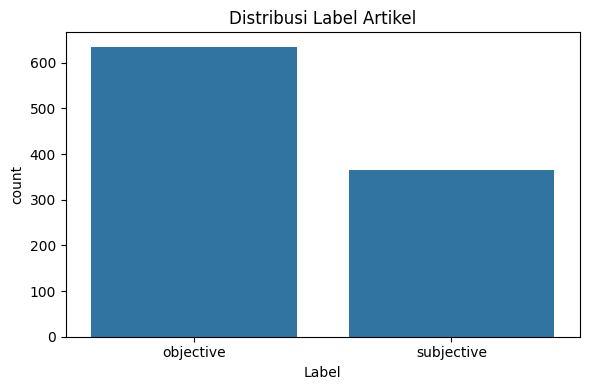

In [6]:
plt.figure(figsize=(6,4))
sns.countplot(x=y)
plt.title('Distribusi Label Artikel')
plt.tight_layout()
plt.savefig('fig1_label_distribution.png')
plt.show()


Distribusi TotalWords

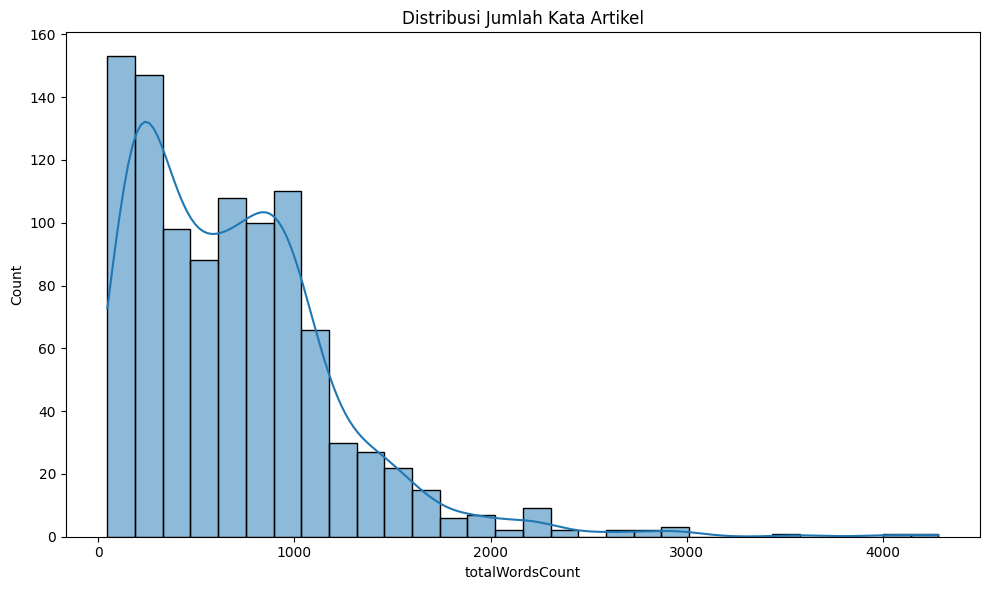

In [7]:
plt.figure(figsize=(10,6))
sns.histplot(df['totalWordsCount'], bins=30, kde=True)
plt.title('Distribusi Jumlah Kata Artikel')
plt.tight_layout()
plt.savefig('fig2_total_words.png')
plt.show()


Heatmap Korelasi

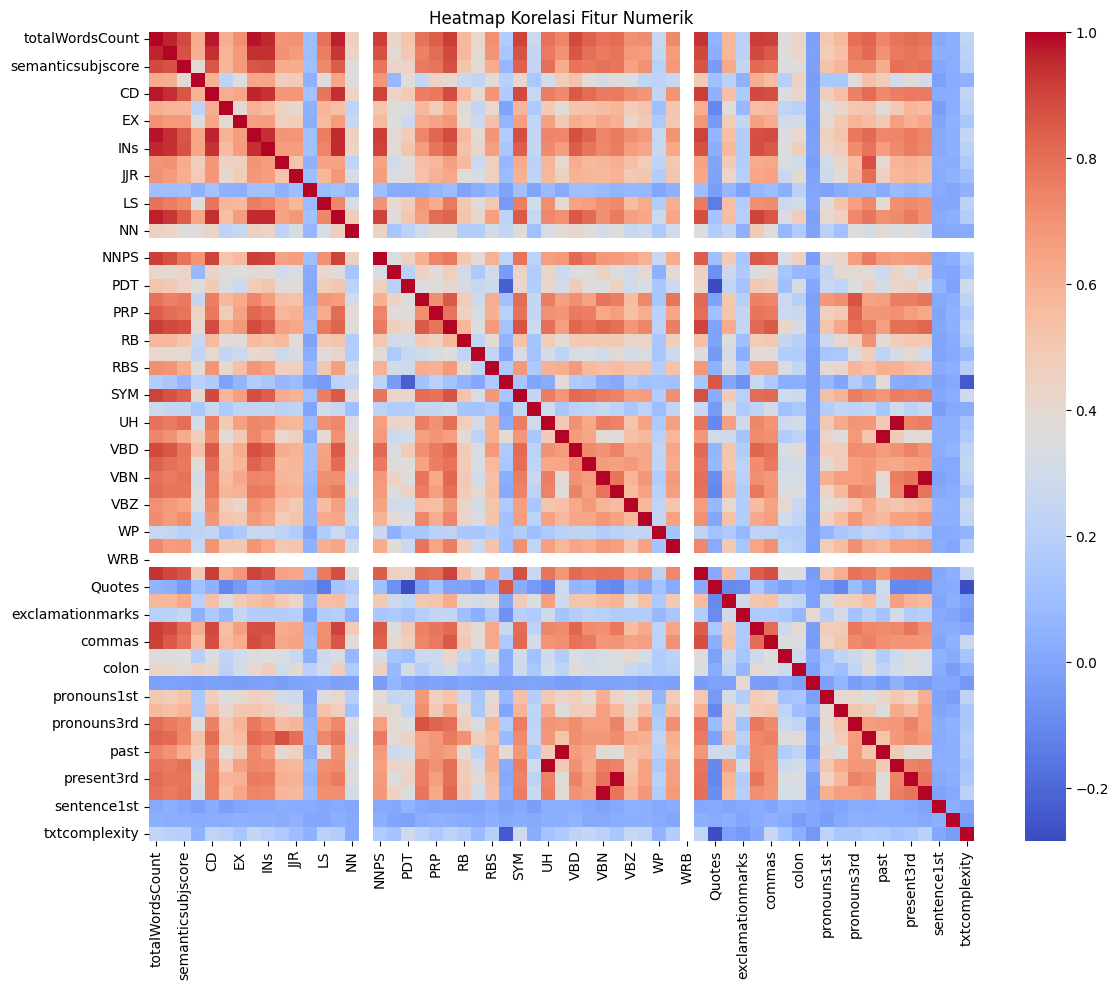

In [8]:
plt.figure(figsize=(12,10))
sns.heatmap(
    df.drop(columns=['TextID','URL','Label']).corr(),
    cmap='coolwarm',
    annot=False
)
plt.title('Heatmap Korelasi Fitur Numerik')
plt.tight_layout()
plt.savefig('fig3_correlation_heatmap.png')
plt.show()


Modeling

LOGISTIC REGRESSION

Training Time Logistic Regression: 0.0439 detik
=== LOGISTIC REGRESSION ===
              precision    recall  f1-score   support

   objective       0.87      0.91      0.89       127
  subjective       0.83      0.75      0.79        73

    accuracy                           0.85       200
   macro avg       0.85      0.83      0.84       200
weighted avg       0.85      0.85      0.85       200

Train Accuracy : 0.8550
Test Accuracy  : 0.8550
Gap            : 0.0000


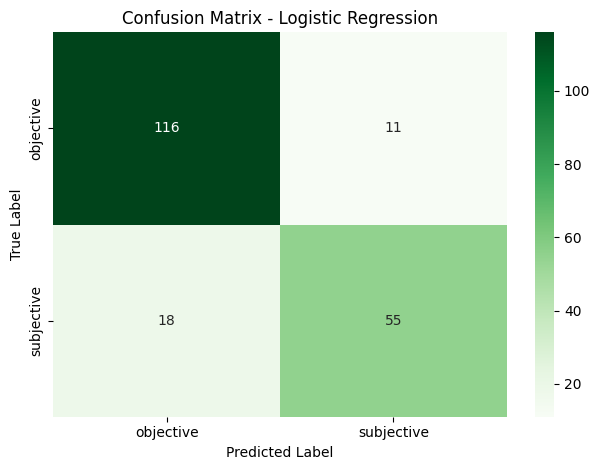

Logistic Regression model saved as 'lr_model.joblib'


In [9]:

# MODEL 1: LOGISTIC REGRESSION

start = time.time()
lr_model = Pipeline(
    [('scaler', StandardScaler()), ('lr', LogisticRegression(max_iter=1000, random_state=SEED))]
)
lr_model.fit(X_train_numeric, y_train)
lr_time = time.time() - start
print(f"Training Time Logistic Regression: {lr_time:.4f} detik")

# Prediction & Evaluation
y_pred_lr = lr_model.predict(X_test_numeric)

lr_acc  = accuracy_score(y_test, y_pred_lr)
lr_prec = precision_score(y_test, y_pred_lr, average='weighted')
lr_rec  = recall_score(y_test, y_pred_lr, average='weighted')
lr_f1   = f1_score(y_test, y_pred_lr, average='weighted')

print("=== LOGISTIC REGRESSION ===")
print(classification_report(y_test, y_pred_lr))

# Overfitting Check
train_acc_lr = lr_model.score(X_train_numeric, y_train)
test_acc_lr  = lr_model.score(X_test_numeric, y_test)
print(f"Train Accuracy : {train_acc_lr:.4f}")
print(f"Test Accuracy  : {test_acc_lr:.4f}")
print(f"Gap            : {train_acc_lr - test_acc_lr:.4f}")

# Confusion Matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(
    cm_lr,
    annot=True,
    fmt='d',
    cmap='Greens',
    xticklabels=lr_model.named_steps['lr'].classes_,
    yticklabels=lr_model.named_steps['lr'].classes_
)
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.savefig('cm_logistic_regression.png') # Added savefig
plt.show()

# Save model
joblib.dump(lr_model, 'lr_model.joblib')
print("Logistic Regression model saved as 'lr_model.joblib'")

RANDOM FOREST

Training Time Random Forest: 1.5338 detik
=== RANDOM FOREST ===
              precision    recall  f1-score   support

   objective       0.88      0.85      0.86       127
  subjective       0.75      0.79      0.77        73

    accuracy                           0.83       200
   macro avg       0.82      0.82      0.82       200
weighted avg       0.83      0.83      0.83       200

Train Accuracy : 0.8712
Test Accuracy  : 0.8300
Gap            : 0.0413


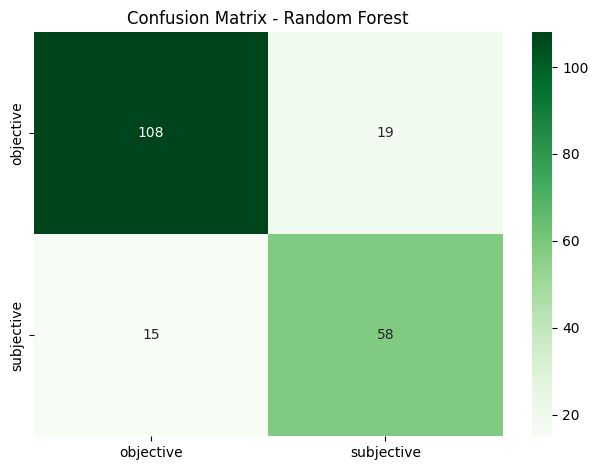

Random Forest model saved as 'rf_model.joblib'


In [10]:
# MODEL 2: RANDOM FOREST

rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=5,
    min_samples_split=20,
    min_samples_leaf=10,
    max_features=0.5,
    random_state=SEED,
    n_jobs=-1
)
start = time.time()
rf_model.fit(X_train_numeric, y_train)
rf_time = time.time() - start
print(f"Training Time Random Forest: {rf_time:.4f} detik")

# Prediction & Evaluation
y_pred_rf = rf_model.predict(X_test_numeric)
rf_acc  = accuracy_score(y_test, y_pred_rf)
rf_prec = precision_score(y_test, y_pred_rf, average='weighted')
rf_rec  = recall_score(y_test, y_pred_rf, average='weighted')
rf_f1   = f1_score(y_test, y_pred_rf, average='weighted')

print("=== RANDOM FOREST ===")
print(classification_report(y_test, y_pred_rf))

# Overfitting Check
train_acc_rf = rf_model.score(X_train_numeric, y_train)
test_acc_rf  = rf_model.score(X_test_numeric, y_test)
print(f"Train Accuracy : {train_acc_rf:.4f}")
print(f"Test Accuracy  : {test_acc_rf:.4f}")
print(f"Gap            : {train_acc_rf - test_acc_rf:.4f}")

# Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(
    cm_rf,
    annot=True,
    fmt='d',
    cmap='Greens',
    xticklabels=rf_model.classes_,
    yticklabels=rf_model.classes_
)
plt.title("Confusion Matrix - Random Forest")
plt.tight_layout()
plt.savefig('cm_random_forest.png') # Added savefig
plt.show()

# Save model
joblib.dump(rf_model, 'rf_model.joblib')
print("Random Forest model saved as 'rf_model.joblib'")

DEEP LEARNING (MLP)

In [11]:
# Split data latih menjadi train & validation (10% dari data latih)
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_numeric,
    y_train,
    test_size=0.1,
    random_state=SEED,
    stratify=y_train
)

# Scaling fitur (fit HANYA di data train)
scaler = StandardScaler()
X_tr_scaled  = scaler.fit_transform(X_tr)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test_numeric)

# Label encoding
le = LabelEncoder()
y_tr_enc  = le.fit_transform(y_tr)
y_val_enc = le.transform(y_val)
y_test_enc = le.transform(y_test)

# Model MLP
mlp_model = Sequential([
    Input(shape=(X_tr_scaled.shape[1],)),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

mlp_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Training
start = time.time()
history = mlp_model.fit(
    X_tr_scaled,
    y_tr_enc,
    epochs=10,
    batch_size=32,
    validation_data=(X_val_scaled, y_val_enc),
    verbose=1
)
mlp_time = time.time() - start
print("Training Time MLP:", round(mlp_time, 4), "detik")

# Evaluation
y_pred_mlp = (mlp_model.predict(X_test_scaled) > 0.5).astype(int).ravel()

dl_acc  = accuracy_score(y_test_enc, y_pred_mlp)
dl_prec = precision_score(y_test_enc, y_pred_mlp)
dl_rec  = recall_score(y_test_enc, y_pred_mlp)
dl_f1   = f1_score(y_test_enc, y_pred_mlp)


print("=== MLP ===")
print(classification_report(y_test_enc, y_pred_mlp))

# Save model
from keras.saving import save_model
save_model(mlp_model, "mlp_model.keras")
print("MLP model saved as 'mlp_model.keras'")

mlp_model.save('mlp_model.h5')
print("MLP model saved as 'mlp_model.h5'")

Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.6817 - loss: 0.6094 - val_accuracy: 0.8625 - val_loss: 0.3416
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7939 - loss: 0.4783 - val_accuracy: 0.9250 - val_loss: 0.3107
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8191 - loss: 0.4160 - val_accuracy: 0.9250 - val_loss: 0.2946
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8280 - loss: 0.4053 - val_accuracy: 0.9250 - val_loss: 0.2872
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8446 - loss: 0.3924 - val_accuracy: 0.9125 - val_loss: 0.2968
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8496 - loss: 0.3714 - val_accuracy: 0.9000 - val_loss: 0.2976
Epoch 7/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8475 - loss: 0.3645 - val_accuracy: 0.8875 - val_loss: 0.2999
Epoch 8/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8568 - loss: 0.3535 - val_accuracy: 0.8875 - val_loss

=== MLP ===
              precision    recall  f1-score   support

           0       0.89      0.87      0.88       127
           1       0.78      0.82      0.80        73

    accuracy                           0.85       200
   macro avg       0.84      0.84      0.84       200
weighted avg       0.85      0.85      0.85       200

MLP model saved as 'mlp_model.keras'
MLP model saved as 'mlp_model.h5'


Plot training history

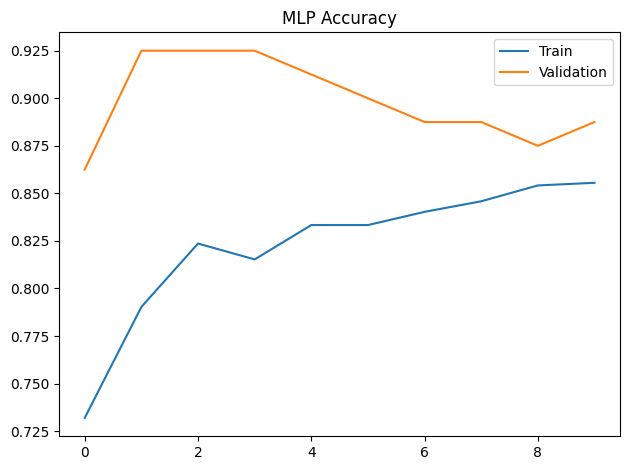

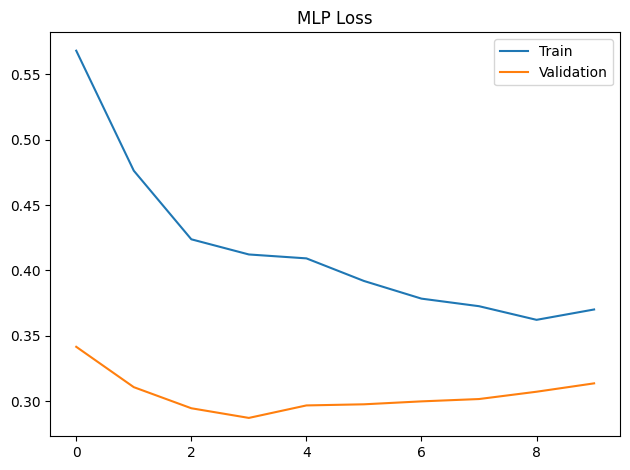

In [12]:
# Plot training history
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('MLP Accuracy')
plt.legend()
plt.tight_layout()
plt.savefig('mlp_accuracy.png') # Added savefig
plt.show()

plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('MLP Loss')
plt.legend()
plt.tight_layout()
plt.savefig('mlp_loss.png') # Added savefig
plt.show()

PERBANDINGAN 3 MODEL

In [13]:
results = pd.DataFrame({
    'Accuracy': [lr_acc, rf_acc, dl_acc],
    'Precision': [lr_prec, rf_prec, dl_prec],
    'Recall': [lr_rec, rf_rec, dl_rec],
    'F1-Score': [lr_f1, rf_f1, dl_f1],
    'Training Time (s)': [lr_time, rf_time, mlp_time]
}, index=['Logistic Regression', 'Random Forest', 'MLP (Deep Learning)'])

results



,Accuracy,Precision,Recall,F1-Score,Training Time (s)
Logistic Regression,0.855,0.853868,0.855000,0.853293,0.043931
Random Forest,0.830,0.832496,0.830000,0.830907,1.533844
MLP (Deep Learning),0.850,0.779221,0.821918,0.800000,4.115017


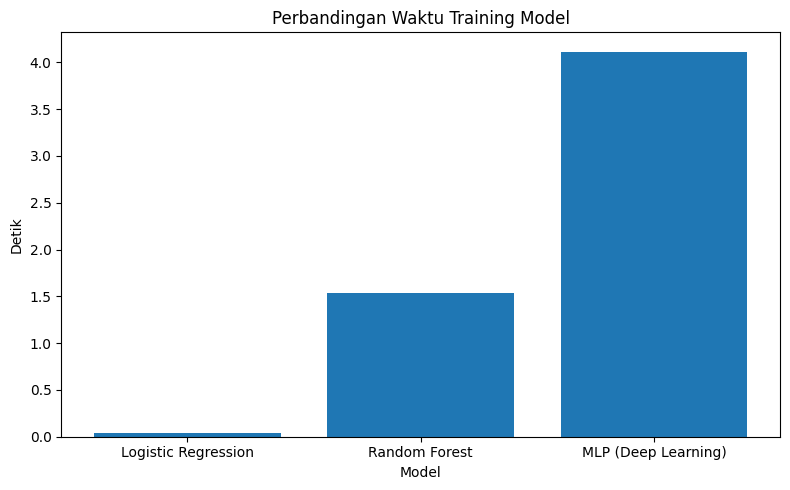

In [14]:
# PERBANDINGAN WAKTU TRAINING


plt.figure(figsize=(8,5))
plt.bar(
    results.index,
    results['Training Time (s)']
)

plt.title('Perbandingan Waktu Training Model')
plt.ylabel('Detik')
plt.xlabel('Model')
plt.tight_layout()
plt.savefig('comparison_training_time.png')
plt.show()


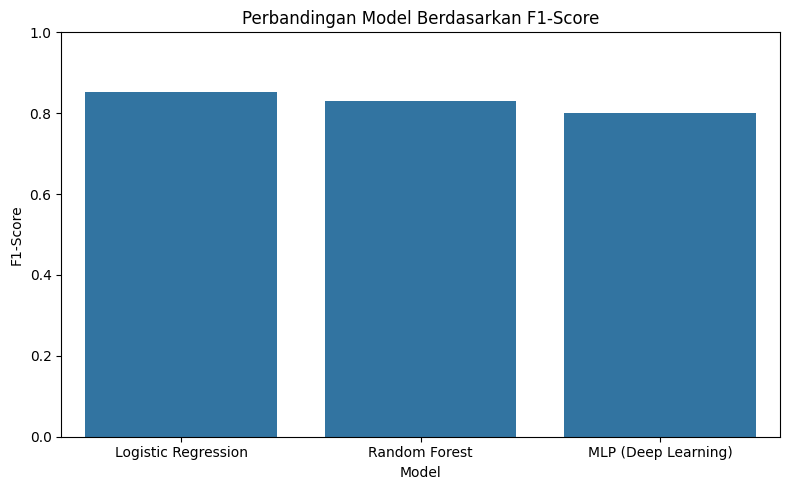

In [15]:
# ===============================
# MODEL TERBAIK (F1-SCORE)
# ===============================

plt.figure(figsize=(8,5))
sns.barplot(
    x=results.index,
    y=results['F1-Score']
)

plt.title('Perbandingan Model Berdasarkan F1-Score')
plt.ylabel('F1-Score')
plt.xlabel('Model')
plt.ylim(0,1)
plt.tight_layout()
plt.savefig('comparison_best_model.png')
plt.show()


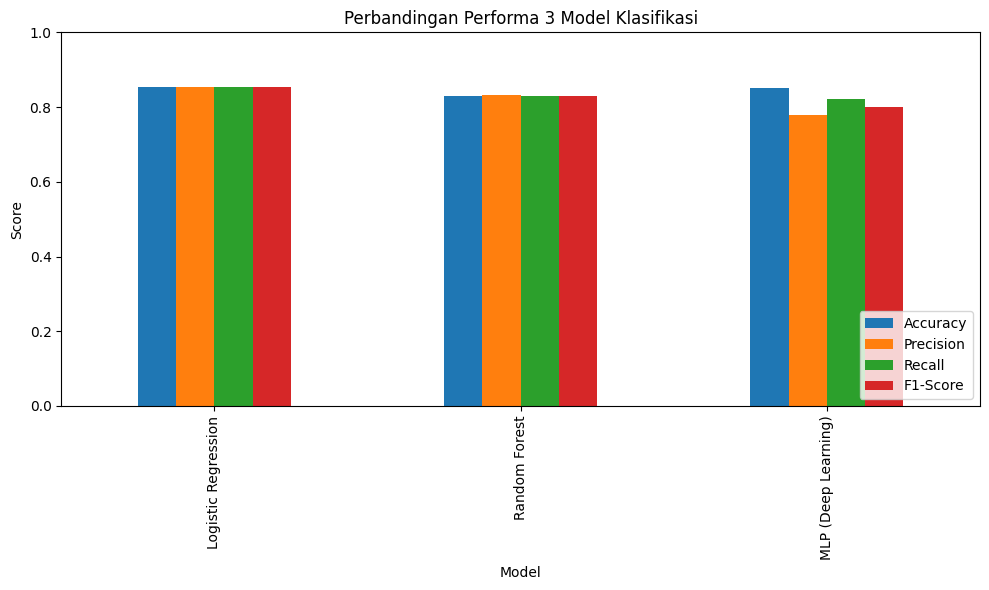

In [16]:
# ===============================
# PERBANDINGAN 3 MODEL (METRIK)
# ===============================

results[['Accuracy', 'Precision', 'Recall', 'F1-Score']].plot(
    kind='bar',
    figsize=(10,6)
)

plt.title('Perbandingan Performa 3 Model Klasifikasi')
plt.ylabel('Score')
plt.xlabel('Model')
plt.ylim(0, 1)
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('comparison_metrics_models.png')
plt.show()


<Figure size 1000x600 with 0 Axes>

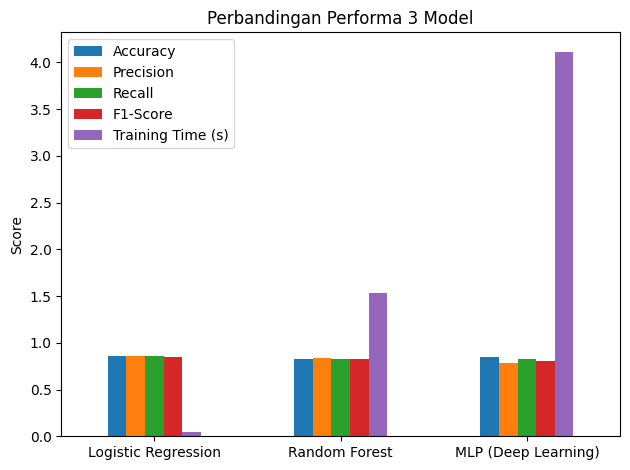

In [17]:
plt.figure(figsize=(10,6))
results.plot(kind='bar')
plt.title('Perbandingan Performa 3 Model')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('comparison_models.png')
plt.show()


In [18]:
mlp_model.summary()

mlp_model.save('mlp_model.keras')
mlp_model.save('mlp_model.h5')

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         7,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 48,005 (187.52 KB)

 Trainable params: 16,001 (62.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 32,004 (125.02 KB)

In [19]:
from google.colab import files
import os
os.listdir()


files_to_download = [
    'fig1_label_distribution.png',
    'fig2_total_words.png',
    'fig3_correlation_heatmap.png',
    'cm_logistic_regression.png',
    'cm_random_forest.png',
    'mlp_accuracy.png',
    'mlp_loss.png',
    'comparison_models.png'
]

for f in files_to_download:
    if os.path.exists(f):
        files.download(f)
    else:
        print(f"❌ File tidak ditemukan: {f}")



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>